In [1]:
# Load Data

In [2]:
import os
print(os.listdir("./heartbeat"))

['mitbih_test.csv', 'mitbih_train.csv', '.ipynb_checkpoints']


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [140]:
train_df=pd.read_csv('./heartbeat/mitbih_train.csv',header=None)
test_df=pd.read_csv('./heartbeat/mitbih_test.csv',header=None)

In [149]:
train_df.shape

(100000, 188)

In [145]:
test_df.shape

(21892, 188)

In [ ]:
# Balance Data

In [21]:
train_df[187] = train_df[187].astype(int)
equilibre = train_df[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


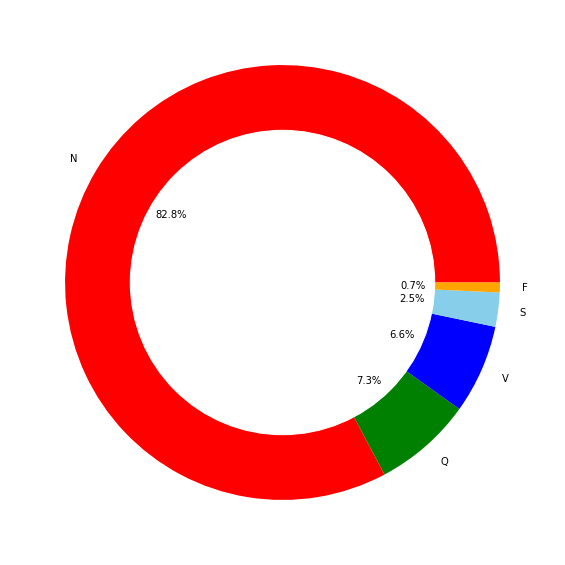

In [32]:
plt.figure(figsize=(12,10))
circle = plt.Circle((0,0), .7, color='white')
plt.pie(equilibre, labels=['N', 'Q', 'V', 'S', 'F'], colors=['red', 'green', 'blue', 'skyblue', 'orange'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.show()

In [33]:
## As you can see, there is an imbalance in the dataset. 
## Resampling the dataset

In [147]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

equilibre=train_df[187].value_counts()
print(equilibre)

1.0    20000
3.0    20000
4.0    20000
2.0    20000
0.0    20000
Name: 187, dtype: int64


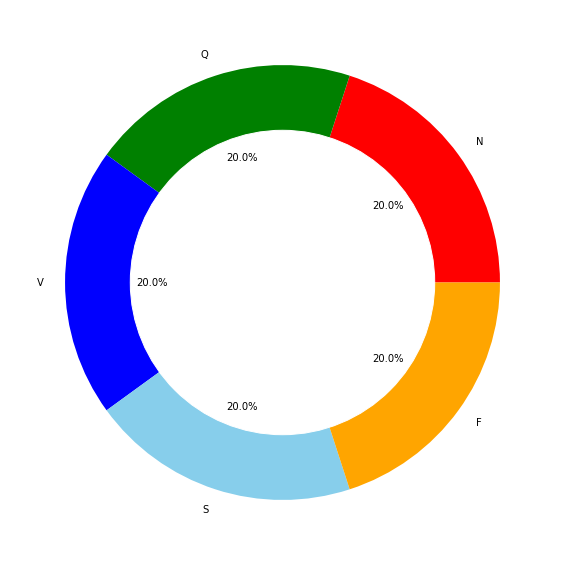

In [36]:
plt.figure(figsize=(12,10))
circle = plt.Circle((0,0), .7, color='white')
plt.pie(equilibre, labels=['N', 'Q', 'V', 'S', 'F'], colors=['red', 'green', 'blue', 'skyblue', 'orange'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.show()

In [45]:
c = train_df.groupby(187, group_keys=False).apply(lambda train_df : train_df.sample(1))
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
51051,0.979351,0.849558,0.383481,0.000000,0.153392,0.333333,0.395280,0.407080,0.454277,0.436578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
72778,0.896000,0.888000,0.248000,0.000000,0.068000,0.144000,0.132000,0.152000,0.200000,0.176000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
77417,0.717391,0.649457,0.396739,0.260870,0.269022,0.239130,0.247283,0.252717,0.279891,0.271739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80758,0.986817,1.000000,0.606403,0.301318,0.167608,0.126177,0.099812,0.082863,0.071563,0.071563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
85359,0.983402,0.514523,0.547718,0.551867,0.551867,0.526971,0.543568,0.489627,0.381743,0.236515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


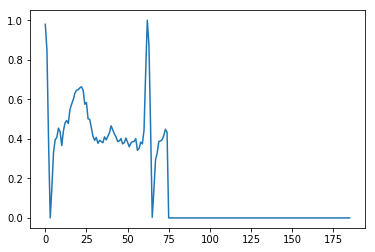

In [50]:
# Plot of a healthy heartbeat
plt.plot(c.iloc[0,:186])

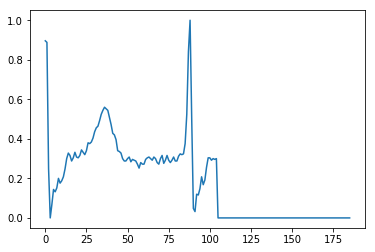

In [52]:
# Plot of a Supraventricular premature beat
plt.plot(c.iloc[1,:186])

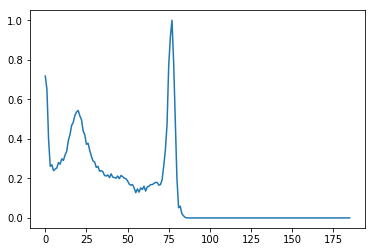

In [53]:
# Plot of a Premature ventricular contraction
plt.plot(c.iloc[2,:186])

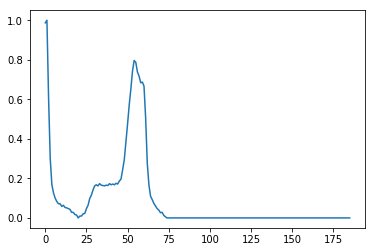

In [54]:
# Plot of a Fusion of ventricular and normal beat
plt.plot(c.iloc[3,:186])

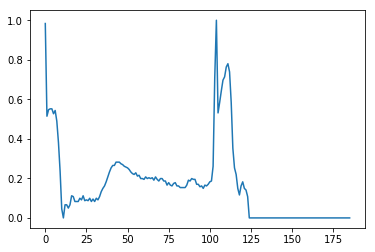

In [55]:
# Plot of a Fusion Unclassifiable beat
plt.plot(c.iloc[4,:186])

In [56]:
# Add noise to generalize train data
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

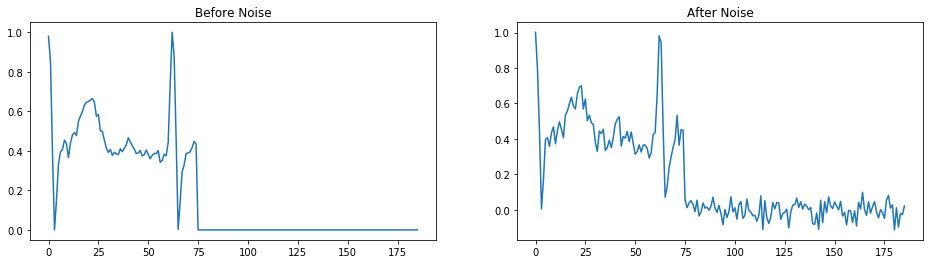

In [73]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)
plt.figure(figsize=(16,4))
# Before noise
plt.subplot(1,2,1)
plt.title('Before Noise')
plt.plot(c.iloc[0,:186])

# After noise
plt.subplot(1,2,2)
plt.title('After Noise')
plt.plot(bruiter)

plt.show()

In [158]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [159]:
y_train.shape

(100000, 5)

In [183]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
# X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_train = X_train[..., np.newaxis] 
# X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [192]:
X_train.shape

(100000, 186, 1)

In [166]:
type(X_train)

numpy.ndarray

In [78]:
# Network

In [76]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='heart_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('heart_model.h5')
    return(model,history)

In [77]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [79]:
# Import Keras for training

In [80]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 100000 samples, validate on 21892 samples
Epoch 1/40
100000/100000 [==============================] - 28s 280us/step - loss: 0.1903 - accuracy: 0.9324 - val_loss: 0.1944 - val_accuracy: 0.9369
Epoch 2/40
100000/100000 [==============================] - 24s 242us/step - loss: 0.0755 - accuracy: 0.9746 - val_loss: 0.1462 - val_accuracy: 0.9536
Epoch 3/40
100000/100000 [==============================] - 25s 246us/step - loss: 0.0502 - accuracy: 0.9833 - val_loss: 0.1284 - val_accuracy: 0.9641
Epoch 4/40
100000/100000 [==============================] - 24s 244us/step - loss: 0.0399 - accuracy: 0.9871 - val_loss: 0.1372 - val_accuracy: 0.9627
Epoch 5/40
100000/100000 [==============================] - 25s 251us/step - loss: 0.0300 - accuracy: 0.9900 - val_loss: 0.1278 - val_accuracy: 0.9707
Epoch 6/40
100000/100000 [==============================] - 24s 244us/step - loss: 0.0259 - accuracy: 0.9918 - 

Accuracy: 97.37%


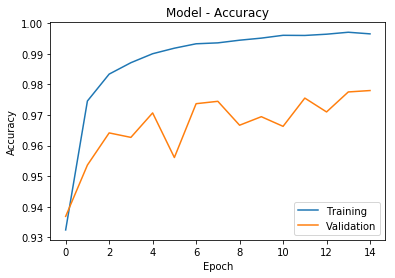

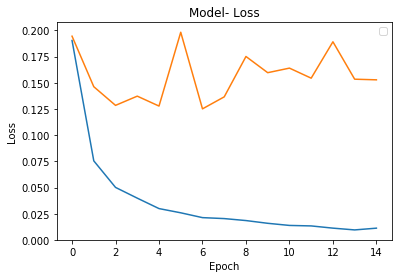

In [129]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)
# y_pred=model.predict(X_test[:1,:])

In [123]:
yy_pred = pd.DataFrame(y_pred)
yy_pred
# X_test[:1,:].shape

,0,1,2,3,4
0,1.0,2.684312e-08,2.573562e-12,1.201838e-10,5.921223e-12


Normalized confusion matrix


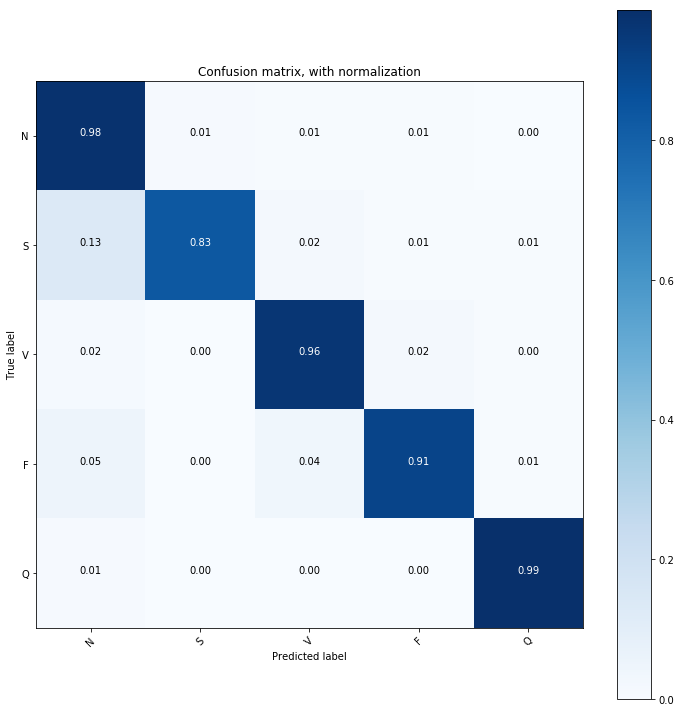

In [130]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()